In [85]:
# Import necessary libraries
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("/home/lyrax/matplotlib-dracula/dracula.mplstyle")
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import datetime

from tqdm import tqdm, trange

In [93]:
data = pd.read_csv("data/data_clean.csv", parse_dates=['participant_date_of_birth', 'treatment_created_date',
                                                       'claim_finalized_date'])
data.head(3)

,Serial Number,claim_status,provider_type,provider_region,program_cover,participant_date_of_birth,participant_gender,treatment_created_date,claim_finalized_date,item_status,item_name,item_amount,item_quantity,total_item_amount,diagnoses
0,162967.0,Approved,Specialist,NAIROBI,DENTAL,1987-12-19,FEMALE,2021-01-19 10:45:21,2021-01-19 22:38:08,APPROVED,Simple Extraction Permanent,3000.0,1,3000.0,Dental caries
1,162967.0,Approved,Specialist,NAIROBI,DENTAL,1987-12-19,FEMALE,2021-01-19 10:45:21,2021-01-19 22:38:08,APPROVED,Dental Consultation,1500.0,1,1500.0,Dental caries
2,164883.0,Approved,Specialist,NAIROBI,DENTAL,1977-01-01,FEMALE,2021-01-22 10:49:08,2021-01-28 10:48:12,APPROVED,Dental consultation,1500.0,1,1500.0,Dental caries


In [94]:
((pd.to_datetime(datetime.date.today()) - data.participant_date_of_birth).dt.days) / 364

0         34.087912
1         34.087912
2         45.087912
3         45.087912
4         45.087912
            ...    
167167    29.695055
167168    29.695055
167169    29.695055
167170    29.695055
167171    29.695055
Name: participant_date_of_birth, Length: 167172, dtype: float64

In [95]:
# new features from dates
data['participant_age'] = ((pd.to_datetime(datetime.date.today()) - data.participant_date_of_birth).dt.days) / 364


data['participant_yearOB'] = data.participant_date_of_birth.dt.year.astype(int)
data['participant_monthOB'] = data.participant_date_of_birth.dt.month.astype(int)
data['participant_dayOB'] = data.participant_date_of_birth.dt.day.astype(int)

data['treat_cr_year'] = data.treatment_created_date.dt.year.astype(int)
data['treat_cr_month'] = data.treatment_created_date.dt.month.astype(int)
data['treat_cr_day'] = data.treatment_created_date.dt.day.astype(int)
data['treat_cr_weekday'] = pd.Series(data.treatment_created_date.dt.weekday).apply(lambda x: 1 if x<5 else 0).astype(int)

data['claim_final_year'] = data.claim_finalized_date.dt.year.astype(int)
data['claim_final_month'] = data.claim_finalized_date.dt.month.astype(int)
data['claim_final_day'] = data.claim_finalized_date.dt.day.astype(int)
data['claim_final_weekday'] = pd.Series(data.claim_finalized_date.dt.weekday).apply(lambda x: 1 if x<5 else 0).astype(int)

data.sample(3)

,Serial Number,claim_status,provider_type,provider_region,program_cover,participant_date_of_birth,participant_gender,treatment_created_date,claim_finalized_date,item_status,item_name,item_amount,item_quantity,total_item_amount,diagnoses,participant_age,participant_yearOB,participant_monthOB,participant_dayOB,treat_cr_year,treat_cr_month,treat_cr_day,treat_cr_weekday,claim_final_year,claim_final_month,claim_final_day,claim_final_weekday
137672,168117.0,Approved,Hospital,MOMBASA,OUTPATIENT,2004-11-07,FEMALE,2021-01-27 15:17:12,2021-01-28 09:30:38,APPROVED,Efferalgan 1g tablets 8s,58.22,8,465.8,Acute pharyngitis,17.142857,2004,11,7,2021,1,27,1,2021,1,28,1
105036,175260.0,Approved,Hospital,KISUMU,OUTPATIENT,1958-04-14,FEMALE,2021-02-03 08:05:15,2021-02-12 20:39:02,APPROVED,Random Blood Sugar,300.00,1,300.0,Calculus of urinary tract in diseases classifi...,63.870879,1958,4,14,2021,2,3,1,2021,2,12,1
5654,169098.0,Approved,Clinic,KISUMU,OUTPATIENT,1965-02-09,FEMALE,2021-01-29 10:15:54,2021-01-29 11:18:49,APPROVED,TOTAL CORPORATE SHARE,4560.00,1,4560.0,Encounter for administrative examination,57.021978,1965,2,9,2021,1,29,1,2021,1,29,1


In [96]:
# days from treatment creation to claim finalization
data['treat_claim_diff'] = (data.claim_finalized_date - data.treatment_created_date).dt.days

In [97]:
le = LabelEncoder()
le.fit_transform(data.provider_type + data.provider_region)

array([118, 118, 118, ...,  35,  35,  35])

In [98]:
data

,Serial Number,claim_status,provider_type,provider_region,program_cover,participant_date_of_birth,participant_gender,treatment_created_date,claim_finalized_date,item_status,item_name,item_amount,item_quantity,total_item_amount,diagnoses,participant_age,participant_yearOB,participant_monthOB,participant_dayOB,treat_cr_year,treat_cr_month,treat_cr_day,treat_cr_weekday,claim_final_year,claim_final_month,claim_final_day,claim_final_weekday,treat_claim_diff
0,162967.0,Approved,Specialist,NAIROBI,DENTAL,1987-12-19,FEMALE,2021-01-19 10:45:21,2021-01-19 22:38:08,APPROVED,Simple Extraction Permanent,3000.0,1,3000.0,Dental caries,34.087912,1987,12,19,2021,1,19,1,2021,1,19,1,0
1,162967.0,Approved,Specialist,NAIROBI,DENTAL,1987-12-19,FEMALE,2021-01-19 10:45:21,2021-01-19 22:38:08,APPROVED,Dental Consultation,1500.0,1,1500.0,Dental caries,34.087912,1987,12,19,2021,1,19,1,2021,1,19,1,0
2,164883.0,Approved,Specialist,NAIROBI,DENTAL,1977-01-01,FEMALE,2021-01-22 10:49:08,2021-01-28 10:48:12,APPROVED,Dental consultation,1500.0,1,1500.0,Dental caries,45.087912,1977,1,1,2021,1,22,1,2021,1,28,1,5
3,164883.0,Approved,Specialist,NAIROBI,DENTAL,1977-01-01,FEMALE,2021-01-22 10:49:08,2021-01-28 10:48:12,APPROVED,Iopa7,1000.0,1,1000.0,Dental caries,45.087912,1977,1,1,2021,1,22,1,2021,1,28,1,5
4,164883.0,Approved,Specialist,NAIROBI,DENTAL,1977-01-01,FEMALE,2021-01-22 10:49:08,2021-01-28 10:48:12,APPROVED,Composite Filling,5000.0,3,15000.0,Dental caries,45.087912,1977,1,1,2021,1,22,1,2021,1,28,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167167,204549.0,Not Approved,Clinic,NYERI,OUTPATIENT,1992-05-05,FEMALE,2021-03-25 14:17:33,2021-03-25 14:17:33,SUBMITTED,H.Pylori Antigen Detection In Stool,1400.0,1,1400.0,Gastroenteritis and colitis due to radiation,29.695055,1992,5,5,2021,3,25,1,2021,3,25,1,0
167168,204549.0,Not Approved,Clinic,NYERI,OUTPATIENT,1992-05-05,FEMALE,2021-03-25 14:17:33,2021-03-25 14:17:33,SUBMITTED,Esomeprazole 40mg/Itopride 150mg capsules 30s,25.0,10,250.0,Gastroenteritis and colitis due to radiation,29.695055,1992,5,5,2021,3,25,1,2021,3,25,1,0
167169,204549.0,Not Approved,Clinic,NYERI,OUTPATIENT,1992-05-05,FEMALE,2021-03-25 14:17:33,2021-03-25 14:17:33,SUBMITTED,Ofloxacin/Ornidazole 200mg/500mg tablets,58.0,10,580.0,Gastroenteritis and colitis due to radiation,29.695055,1992,5,5,2021,3,25,1,2021,3,25,1,0
167170,204549.0,Not Approved,Clinic,NYERI,OUTPATIENT,1992-05-05,FEMALE,2021-03-25 14:17:33,2021-03-25 14:17:33,SUBMITTED,Revist Consultation,0.0,1,0.0,Gastroenteritis and colitis due to radiation,29.695055,1992,5,5,2021,3,25,1,2021,3,25,1,0


/home/lyrax/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_item_amount', ylabel='Density'>

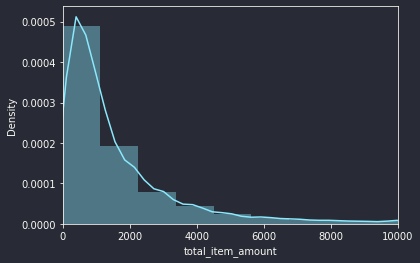

In [99]:
plt.xlim([0, 10000])
sns.distplot(data.total_item_amount)

In [100]:
# categorize some continuous variables from information on plots above
data['totals_cat'] = np.select([
    data.total_item_amount <= 1200,
    (data.total_item_amount > 1200) & (data.total_item_amount <= 2300),
    (data.total_item_amount > 2300) & (data.total_item_amount <= 4500),
    (data.total_item_amount > 4500) & (data.total_item_amount <= 10000),
    data.total_item_amount > 10000
], [3, 5, 1, 2, 4])

data

,Serial Number,claim_status,provider_type,provider_region,program_cover,participant_date_of_birth,participant_gender,treatment_created_date,claim_finalized_date,item_status,item_name,item_amount,item_quantity,total_item_amount,diagnoses,participant_age,participant_yearOB,participant_monthOB,participant_dayOB,treat_cr_year,treat_cr_month,treat_cr_day,treat_cr_weekday,claim_final_year,claim_final_month,claim_final_day,claim_final_weekday,treat_claim_diff,totals_cat
0,162967.0,Approved,Specialist,NAIROBI,DENTAL,1987-12-19,FEMALE,2021-01-19 10:45:21,2021-01-19 22:38:08,APPROVED,Simple Extraction Permanent,3000.0,1,3000.0,Dental caries,34.087912,1987,12,19,2021,1,19,1,2021,1,19,1,0,1
1,162967.0,Approved,Specialist,NAIROBI,DENTAL,1987-12-19,FEMALE,2021-01-19 10:45:21,2021-01-19 22:38:08,APPROVED,Dental Consultation,1500.0,1,1500.0,Dental caries,34.087912,1987,12,19,2021,1,19,1,2021,1,19,1,0,5
2,164883.0,Approved,Specialist,NAIROBI,DENTAL,1977-01-01,FEMALE,2021-01-22 10:49:08,2021-01-28 10:48:12,APPROVED,Dental consultation,1500.0,1,1500.0,Dental caries,45.087912,1977,1,1,2021,1,22,1,2021,1,28,1,5,5
3,164883.0,Approved,Specialist,NAIROBI,DENTAL,1977-01-01,FEMALE,2021-01-22 10:49:08,2021-01-28 10:48:12,APPROVED,Iopa7,1000.0,1,1000.0,Dental caries,45.087912,1977,1,1,2021,1,22,1,2021,1,28,1,5,3
4,164883.0,Approved,Specialist,NAIROBI,DENTAL,1977-01-01,FEMALE,2021-01-22 10:49:08,2021-01-28 10:48:12,APPROVED,Composite Filling,5000.0,3,15000.0,Dental caries,45.087912,1977,1,1,2021,1,22,1,2021,1,28,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167167,204549.0,Not Approved,Clinic,NYERI,OUTPATIENT,1992-05-05,FEMALE,2021-03-25 14:17:33,2021-03-25 14:17:33,SUBMITTED,H.Pylori Antigen Detection In Stool,1400.0,1,1400.0,Gastroenteritis and colitis due to radiation,29.695055,1992,5,5,2021,3,25,1,2021,3,25,1,0,5
167168,204549.0,Not Approved,Clinic,NYERI,OUTPATIENT,1992-05-05,FEMALE,2021-03-25 14:17:33,2021-03-25 14:17:33,SUBMITTED,Esomeprazole 40mg/Itopride 150mg capsules 30s,25.0,10,250.0,Gastroenteritis and colitis due to radiation,29.695055,1992,5,5,2021,3,25,1,2021,3,25,1,0,3
167169,204549.0,Not Approved,Clinic,NYERI,OUTPATIENT,1992-05-05,FEMALE,2021-03-25 14:17:33,2021-03-25 14:17:33,SUBMITTED,Ofloxacin/Ornidazole 200mg/500mg tablets,58.0,10,580.0,Gastroenteritis and colitis due to radiation,29.695055,1992,5,5,2021,3,25,1,2021,3,25,1,0,3
167170,204549.0,Not Approved,Clinic,NYERI,OUTPATIENT,1992-05-05,FEMALE,2021-03-25 14:17:33,2021-03-25 14:17:33,SUBMITTED,Revist Consultation,0.0,1,0.0,Gastroenteritis and colitis due to radiation,29.695055,1992,5,5,2021,3,25,1,2021,3,25,1,0,3


/home/lyrax/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='item_quantity', ylabel='Density'>

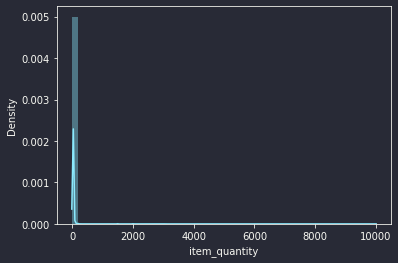

In [101]:
sns.distplot(data.item_quantity)

In [102]:
data[data.item_quantity < 0]

,Serial Number,claim_status,provider_type,provider_region,program_cover,participant_date_of_birth,participant_gender,treatment_created_date,claim_finalized_date,item_status,item_name,item_amount,item_quantity,total_item_amount,diagnoses,participant_age,participant_yearOB,participant_monthOB,participant_dayOB,treat_cr_year,treat_cr_month,treat_cr_day,treat_cr_weekday,claim_final_year,claim_final_month,claim_final_day,claim_final_weekday,treat_claim_diff,totals_cat
